# Adult
> Clasificación

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from functools import reduce

from sklearn.ensemble import GradientBoostingClassifier

# Cargar mi repo como paquete
from sklearn.datasets import load_boston
import sys
from os.path import abspath

try:
    from src.gaparsimony import GAparsimony
except:
    sys.path.append(abspath("C:/Users/Millan/Desktop/GAparsimony"))
    from src.gaparsimony import GAparsimony

In [2]:
df = pd.read_csv("../../data/adult.csv")
print(df.shape)
df.dropna(inplace=True)
df = df.loc[np.random.choice(df.index, 500, replace=False)]
df.head()

(48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
43363,29.0,0.0,190777.0,0.0,13.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,55.0,0.0,<=50K
23217,25.0,0.0,34402.0,0.0,13.0,2.0,4.0,3.0,0.0,1.0,0.0,1590.0,60.0,0.0,<=50K
1176,22.0,0.0,202153.0,1.0,10.0,2.0,8.0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,<=50K
27660,48.0,0.0,254809.0,12.0,6.0,1.0,7.0,5.0,0.0,0.0,0.0,1594.0,32.0,0.0,<=50K
24440,27.0,4.0,74056.0,0.0,13.0,2.0,0.0,3.0,0.0,1.0,0.0,0.0,50.0,0.0,<=50K


In [3]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_train = pd.DataFrame(X_train, columns=df.columns[:-1]).reset_index(drop=True)
data_test = pd.DataFrame(X_test, columns=df.columns[:-1]).reset_index(drop=True)

print(f"train: {data_train.shape} test: {data_test.shape}")

train: (400, 14) test: (100, 14)


In [4]:
data_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,64.0,0.0,180401.0,12.0,6.0,0.0,10.0,2.0,0.0,1.0,0.0,0.0,40.0,0.0
1,22.0,6.0,302347.0,3.0,9.0,2.0,6.0,1.0,0.0,1.0,4416.0,0.0,40.0,0.0
2,35.0,0.0,29874.0,1.0,10.0,0.0,6.0,2.0,0.0,1.0,0.0,0.0,40.0,0.0
3,28.0,0.0,134890.0,0.0,13.0,2.0,3.0,1.0,0.0,1.0,0.0,1974.0,50.0,0.0
4,63.0,1.0,141962.0,12.0,6.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,20.0,0.0


In [5]:
data_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,22.0,0.0,109456.0,1.0,10.0,2.0,6.0,1.0,0.0,1.0,0.0,0.0,32.0,0.0
1,47.0,4.0,47270.0,5.0,12.0,3.0,8.0,5.0,4.0,0.0,0.0,0.0,40.0,0.0
2,55.0,0.0,172666.0,1.0,10.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,40.0,0.0
3,41.0,4.0,189956.0,0.0,13.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,40.0,0.0
4,52.0,0.0,165998.0,1.0,10.0,0.0,7.0,2.0,0.0,1.0,0.0,0.0,40.0,0.0


In [6]:
def fitness(chromosome):
    # First two values in chromosome are 'C' & 'sigma' of 'svmRadial' method
    tuneGrid = {
                "n_estimators": int(chromosome[0]),
                "max_depth": int(chromosome[1]),
                "min_samples_split": int(chromosome[2]),
                "min_weight_fraction_leaf": chromosome[3],
                "subsample": chromosome[4],
                "learning_rate": 0.01,
                "random_state": 1234,
                "verbose": 0}
    
    # Next values of chromosome are the selected features (TRUE if > 0.50)
    selec_feat = chromosome[5:]>0.50
    
    # Return -Inf if there is not selected features
    if np.sum(selec_feat)<1:
        return np.array([np.NINF, np.NINF, np.Inf])
    
    # Extract features from the original DB plus response (last column)
    data_train_model = data_train.loc[: , data_train.columns[selec_feat]] 
    data_test_model = data_test.loc[: , data_test.columns[selec_feat]] 
    
    # How to validate each individual
    # 'repeats' could be increased to obtain a more robust validation metric. Also,
    # 'number' of folds could be adjusted to improve the measure.
    train_control = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)

    # train the model
#     np.random.seed(1234)

    aux = GradientBoostingClassifier(**tuneGrid)

    model = cross_val_score(aux, data_train_model, y_train, scoring=make_scorer(f1_score, average="binary", pos_label='>50K'), cv=train_control, n_jobs=-1)


    # Extract kappa statistics (the repeated k-fold CV and the kappa with the test DB)
    f1_val = model.mean()

    model = GradientBoostingClassifier(**tuneGrid).fit(data_train_model, y_train)

    f1_test = f1_score(model.predict(data_test_model), y_test, average="binary", pos_label='>50K')
    # Obtain Complexity = Num_Features*1E6+Number of support vectors
    complexity = np.sum(selec_feat)*1E6 + len(model.estimators_)
    
    # Return(validation score, testing score, model_complexity)
    return np.array([f1_val, f1_test, complexity])

In [10]:
# Ranges of size and decay
min_param = np.array([10, 2, 2, 0., 0.])
max_param = np.array([2000, 20, 20, .5, 1.])
names_param = ["n_estimators(nrounds)","max_depth", "min_samples_split", 
               "min_weight_fraction_leaf", "subsample"]

# ga_parsimony can be executed with a different set of 'rerank_error' values
rerank_error = 0.01

In [11]:
GAparsimony_model = GAparsimony(fitness=fitness,
                                  min_param=min_param,
                                  max_param=max_param,
                                  names_param=names_param,
                                  nFeatures=len(df.columns[:-1]),
                                  names_features=df.columns[:-1],
                                  keep_history = True,
                                  rerank_error = rerank_error,
                                  popSize = 40,
                                  elitism = 3,
                                  maxiter = 25, early_stop=10,
                                  feat_thres=0.90, # Perc selected features in first generation
                                  feat_mut_thres=0.10, # Prob of a feature to be one in mutation
                                  parallel = True, seed_ini = 1234,
                                  verbose=GAparsimony.MONITOR)

In [12]:
GAparsimony_model.fit()

GA-PARSIMONY | iter = 0
  MeanVal = 0.5259949  |  ValBest = 0.6586921  |  TstBest = 0.5853659  | ComplexBest = 10001744.0 | Time(min) = 6.3397985  

GA-PARSIMONY | iter = 1
  MeanVal = 0.6385115  |  ValBest = 0.6666509  |  TstBest = 0.5128205  | ComplexBest = 10000827.0 | Time(min) = 6.9184771  

GA-PARSIMONY | iter = 2
  MeanVal = 0.6445274  |  ValBest = 0.6813948  |  TstBest = 0.5238095  | ComplexBest = 9000986.0  | Time(min) = 8.0965464  

GA-PARSIMONY | iter = 3
   MeanVal = 0.646593  |  ValBest = 0.6762964  |  TstBest = 0.6341463  | ComplexBest = 7000406.0  | Time(min) = 7.5944585  

GA-PARSIMONY | iter = 4
  MeanVal = 0.6320841  |  ValBest = 0.6899165  |  TstBest = 0.6341463  | ComplexBest = 7000296.0  | Time(min) = 7.4535948  

GA-PARSIMONY | iter = 5
  MeanVal = 0.6250194  |   ValBest = 0.690928  |  TstBest = 0.6341463  | ComplexBest = 7000296.0  | Time(min) = 5.1372157  

GA-PARSIMONY | iter = 6
  MeanVal = 0.6460841  |   ValBest = 0.704808  |     TstBest = 0.65    | ComplexBe

In [13]:
GAparsimony_model.summary()

+------------------------------------+
|             GA-PARSIMONY           |
+------------------------------------+

GA-PARSIMONY settings:
 Number of Parameters      = 5
 Number of Features        = 14
 Population size           = 40
 Maximum of generations    = 25
 Number of early-stop gen. = 10
 Elitism                   = 3
 Crossover probability     = 0.8
 Mutation probability      = 0.1
 Max diff(error) to ReRank = 0.01
 Perc. of 1s in first popu.= 0.9
 Prob. to be 1 in mutation = 0.1

 Search domain = 
           n_estimators(nrounds)  max_depth  min_samples_split  \
Min_param                   10.0        2.0                2.0   
Max_param                 2000.0       20.0               20.0   

           min_weight_fraction_leaf  subsample  age  workclass  fnlwgt  \
Min_param                       0.0        0.0  0.0        0.0     0.0   
Max_param                       0.5        1.0  1.0        1.0     1.0   

           education  education-num  marital-status  occupatio

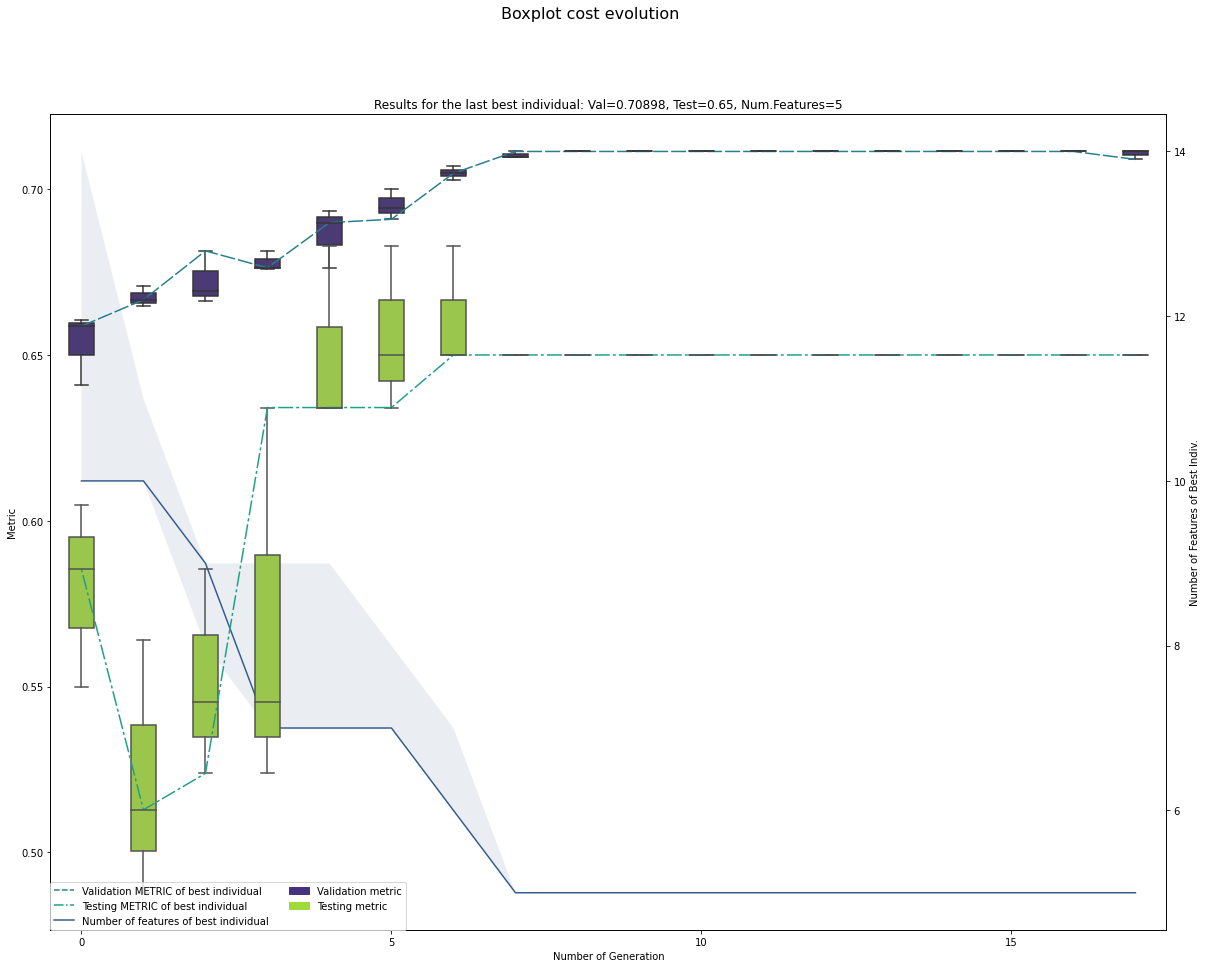

In [14]:
GAparsimony_model.plot(size_plot=(20,15))